# Task 0: Colored-MNIST Dataset

I'm creating a biased MNIST dataset where each digit has a "dominant" color 95% of the time in train/val, but the test set has inverted colors (0s are never red, etc). This lets me study how models learn spurious correlations.

In [1]:
import sys
from pathlib import Path

# find repo root robustly (works whether jupyter runs from notebooks/ or repo root)
ROOT = Path().resolve()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

import numpy as np
import matplotlib.pyplot as plt
import torch

from src.utils.seed import seed_everything, SeedConfig
from src.data import generate_colored_mnist, load_meta, get_color_palette, get_color_names, make_dominant_color_map
from src.data import load_split, compute_overall_correlation, compute_empirical_correlation, get_dataloaders

SEED = 42
DATA_DIR = ROOT / "data" / "colored_mnist"
seed_everything(SeedConfig(seed=SEED))

print(f"data will be at: {DATA_DIR}")

/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

data will be at: /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist


## Generate the dataset

In [2]:
# generate if it doesnt exist yet
if not (DATA_DIR / "meta.json").exists():
    generate_colored_mnist(DATA_DIR, seed=SEED, corr=0.95, test_mode="inverted")
else:
    print("dataset already exists, skipping generation")

meta = load_meta(DATA_DIR)
print(f"\nseed: {meta['seed']}, correlation: {meta['correlation']}")
print(f"splits: {meta['splits']}")

generating colored-mnist (seed=42, corr=0.95)
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:09<00:00, 1.08MB/s]


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/train-images-idx3-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 95.1kB/s]


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:02<00:00, 634kB/s] 


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.03MB/s]


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

splits: train=54000, val=6000, test=10000
  saved train: 54000 samples
  saved val: 6000 samples
  saved test_hard: 10000 samples

verification:
  train: 95.0% dominant (ok)
  val: 95.3% dominant (ok)
  test_hard: 0.0% dominant (ok)

done! saved to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist

seed: 42, correlation: 0.95
splits: {'train': 54000, 'val': 6000, 'test_hard': 10000}


## Verify correlation stats

This is the important part - I need to make sure train/val have ~95% dominant color and test_hard has ~0%.

In [3]:
dominant_map = make_dominant_color_map()
color_names = get_color_names()

print("overall correlation (should be ~95% for train/val, ~0% for test):")
for split in ["train", "val", "test_hard"]:
    data = load_split(DATA_DIR, split)
    corr = compute_overall_correlation(data["labels"], data["color_ids"], dominant_map)
    print(f"  {split}: {corr*100:.1f}%")

overall correlation (should be ~95% for train/val, ~0% for test):


/Users/lohithkola/Desktop/projects/The-Lazy-Artist/src/data/datasets.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(Path(root) / f"{split}.pt", map_l

  train: 95.0%
  val: 95.3%
  test_hard: 0.0%


In [4]:
# per-digit breakdown for train
train_data = load_split(DATA_DIR, "train")
per_digit = compute_empirical_correlation(train_data["labels"], train_data["color_ids"], dominant_map)
print("per-digit correlation (train):")
for d, c in per_digit.items():
    print(f"  digit {d} ({color_names[d]}): {c*100:.1f}%")

per-digit correlation (train):
  digit 0 (red): 94.9%
  digit 1 (green): 95.3%
  digit 2 (blue): 94.8%
  digit 3 (yellow): 94.8%
  digit 4 (purple): 95.1%
  digit 5 (cyan): 95.2%
  digit 6 (orange): 94.9%
  digit 7 (pink): 95.5%
  digit 8 (brown): 95.0%
  digit 9 (gray): 94.9%


## Sample images

Some samples to make sure the colorization looks right.

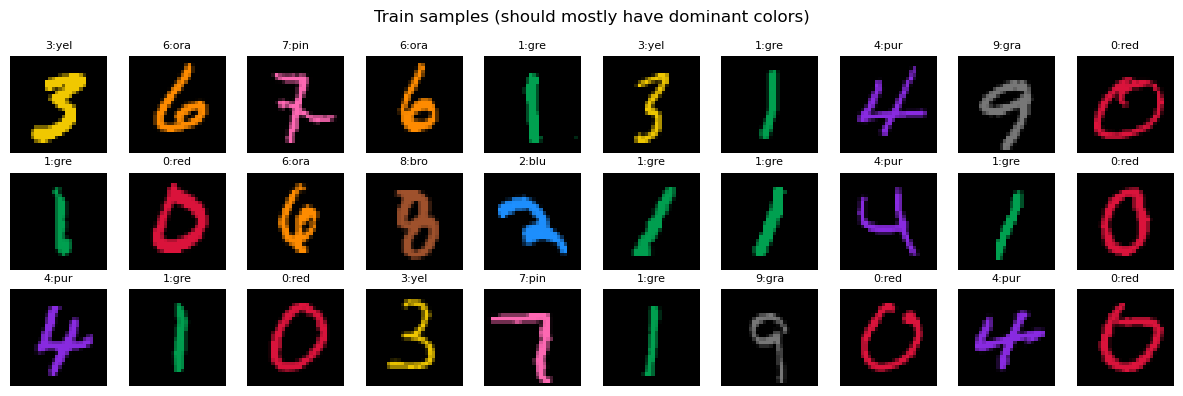

In [5]:
def show_samples(data, title, n=30):
    fig, axes = plt.subplots(3, 10, figsize=(12, 4))
    for i, ax in enumerate(axes.flat):
        if i >= n:
            ax.axis('off')
            continue
        img = data["images"][i].permute(1, 2, 0).numpy()
        label = int(data["labels"][i])
        color_id = int(data["color_ids"][i])
        ax.imshow(img)
        ax.set_title(f"{label}:{color_names[color_id][:3]}", fontsize=8)
        ax.axis('off')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

show_samples(train_data, "Train samples (should mostly have dominant colors)")

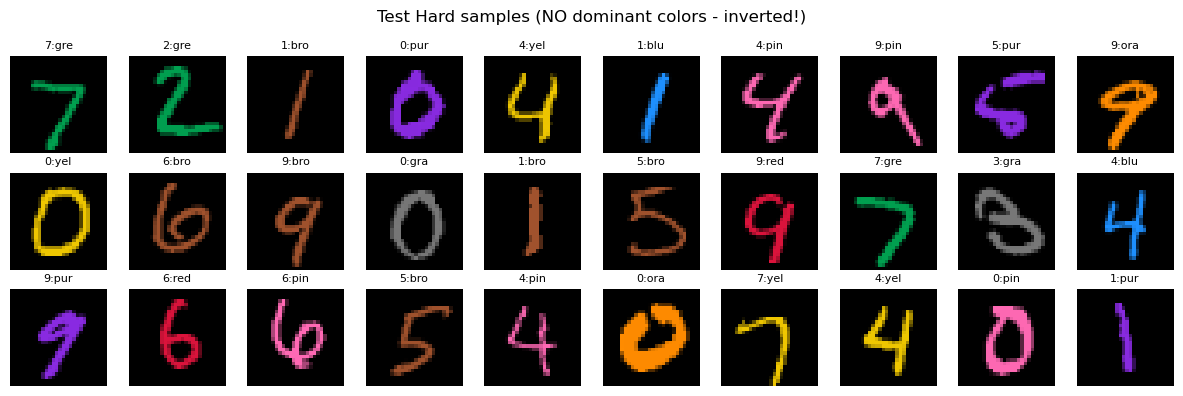

In [6]:
test_data = load_split(DATA_DIR, "test_hard")
show_samples(test_data, "Test Hard samples (NO dominant colors - inverted!)")

## Quick dataloader test

In [7]:
loaders = get_dataloaders({"root": str(DATA_DIR), "batch_size": 64, "num_workers": 0})
print("dataloaders:")
for name, loader in loaders.items():
    print(f"  {name}: {len(loader.dataset)} samples, {len(loader)} batches")

# quick check
imgs, labels = next(iter(loaders["train"]))
print(f"\nbatch shape: {imgs.shape}, range: [{imgs.min():.2f}, {imgs.max():.2f}]")

dataloaders:
  train: 54000 samples, 844 batches
  val: 6000 samples, 94 batches
  test_hard: 10000 samples, 157 batches

batch shape: torch.Size([64, 3, 28, 28]), range: [0.00, 1.00]


/Users/lohithkola/Desktop/projects/The-Lazy-Artist/src/data/datasets.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(self.root / f"{split}.pt", map_lo

## Done

Dataset looks good. Train/val have ~95% dominant color, test_hard has 0%. The colors are applied to the strokes (not flat background). Ready for Task 1.